In [1]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    r = requests.get(url, stream=True)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)

extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")


In [2]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()


/tmp/ipykernel_176/3975563960.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


In [3]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')


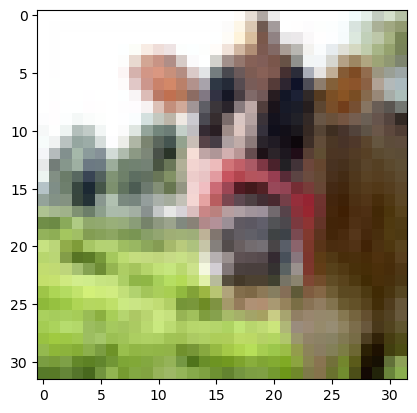

In [4]:
import numpy as np
import matplotlib.pyplot as plt

row = dataset_train[b'data'][0]

test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

plt.imshow(test_image)
plt.show()


In [5]:
import pandas as pd

df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

df_train = df_train[df_train["labels"].isin([8, 48])]
df_train["filenames"] = df_train["filenames"].apply(lambda x: x.decode("utf-8"))

df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

df_test = df_test[df_test["labels"].isin([8, 48])]
df_test["filenames"] = df_test["filenames"].apply(lambda x: x.decode("utf-8"))


In [6]:
import os

os.makedirs("train", exist_ok=True)
os.makedirs("test", exist_ok=True)

def save_images(df, data, path):
    for _, row in df.iterrows():
        img_data = data[b'data'][row["row"]]
        img = np.dstack((
            img_data[0:1024].reshape(32, 32),
            img_data[1024:2048].reshape(32, 32),
            img_data[2048:].reshape(32, 32)
        ))
        plt.imsave(f"{path}/{row['filenames']}", img)

save_images(df_train, dataset_train, "train")
save_images(df_test, dataset_test, "test")


In [7]:
import sagemaker
import boto3

sess = sagemaker.Session()
bucket = sess.default_bucket()
region = boto3.Session().region_name
role = sagemaker.get_execution_role()

print("Default Bucket:", bucket)
print("AWS Region:", region)
print("RoleArn:", role)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Default Bucket: sagemaker-us-east-1-980921756982
AWS Region: us-east-1
RoleArn: arn:aws:iam::980921756982:role/service-role/AmazonSageMaker-ExecutionRole-20250802T181425


In [8]:
import os

# set environment variable for shell commands
os.environ["DEFAULT_S3_BUCKET"] = bucket

# sync the folders
!aws s3 sync ./train s3://$DEFAULT_S3_BUCKET/train/
!aws s3 sync ./test s3://$DEFAULT_S3_BUCKET/test/


upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-980921756982/train/bicycle_s_000021.png
upload: train/bicycle_s_000043.png to s3://sagemaker-us-east-1-980921756982/train/bicycle_s_000043.png
upload: train/bicycle_s_000035.png to s3://sagemaker-us-east-1-980921756982/train/bicycle_s_000035.png
upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-980921756982/train/bicycle_s_000017.png
upload: train/bicycle_s_000071.png to s3://sagemaker-us-east-1-980921756982/train/bicycle_s_000071.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-980921756982/train/bicycle_s_000038.png
upload: train/bicycle_s_000099.png to s3://sagemaker-us-east-1-980921756982/train/bicycle_s_000099.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-east-1-980921756982/train/bicycle_s_000039.png
upload: train/bicycle_s_000051.png to s3://sagemaker-us-east-1-980921756982/train/bicycle_s_000051.png
upload: train/bicycle_s_000159.png to s3://sagemaker-us-east-1-9809217569

In [9]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )

to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")


In [10]:
import boto3

boto3.Session().resource('s3').Bucket(bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(bucket).Object('test.lst').upload_file('./test.lst')


In [11]:
from sagemaker import image_uris

algo_image = image_uris.retrieve(framework='image-classification', region=region)
s3_output_location = f"s3://{bucket}/models/image_model"


In [12]:
from sagemaker.estimator import Estimator

img_classifier_model = Estimator(
    image_uri=algo_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size=50,
    max_run=3600,
    input_mode='File',
    output_path=s3_output_location,
    sagemaker_session=sess
)


In [13]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32',
    num_classes=2,
    num_training_samples=len(df_train)
)


In [14]:
from sagemaker.inputs import TrainingInput

model_inputs = {
    "train": TrainingInput(
        s3_data=f"s3://{bucket}/train/",
        content_type="application/x-image"
    ),
    "validation": TrainingInput(
        s3_data=f"s3://{bucket}/test/",
        content_type="application/x-image"
    ),
    "train_lst": TrainingInput(
        s3_data=f"s3://{bucket}/train.lst",
        content_type="application/x-image"
    ),
    "validation_lst": TrainingInput(
        s3_data=f"s3://{bucket}/test.lst",
        content_type="application/x-image"
    )
}


In [15]:
img_classifier_model.fit(inputs=model_inputs)


INFO:sagemaker:Creating training-job with name: image-classification-2025-08-02-19-12-52-919


2025-08-02 19:12:54 Starting - Starting the training job
2025-08-02 19:12:54 Pending - Training job waiting for capacity......
2025-08-02 19:13:53 Downloading - Downloading input data...
2025-08-02 19:14:13 Downloading - Downloading the training image...............
2025-08-02 19:16:40 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Aug  2 19:17:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Me

In [16]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)


In [17]:
deployment = img_classifier_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
)

endpoint = deployment.endpoint_name
print(endpoint)


INFO:sagemaker:Creating model with name: image-classification-2025-08-02-19-21-34-805
INFO:sagemaker:Creating endpoint-config with name image-classification-2025-08-02-19-21-34-805
INFO:sagemaker:Creating endpoint with name image-classification-2025-08-02-19-21-34-805


--------!image-classification-2025-08-02-19-21-34-805


In [18]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
import base64

predictor = Predictor(endpoint_name=endpoint)
predictor.serializer = IdentitySerializer("image/png")

# Use an actual image path from test folder
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

inference = predictor.predict(payload)
print(inference)


b'[0.9992033839225769, 0.0007966870907694101]'


In [19]:
print(deployment.endpoint_name)


image-classification-2025-08-02-19-21-34-805


In [26]:
import sagemaker
sess   = sagemaker.Session()
bucket = sess.default_bucket()
print("Default SageMaker bucket:", bucket)


Default SageMaker bucket: sagemaker-us-east-1-980921756982


In [30]:
import random
import boto3
import json

def generate_test_case():
    s3 = boto3.resource('s3')
    # Filter by Prefix="test/" so you only get objects in that folder
    keys = [obj.key for obj in s3.Bucket(bucket).objects.filter(Prefix="test/")]
    obj  = random.choice(keys)
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })

# Test it
print(generate_test_case())


{"image_data": "", "s3_bucket": "sagemaker-us-east-1-980921756982", "s3_key": "test/bike_s_001216.png"}


In [32]:
import boto3
sf = boto3.client("stepfunctions")

resp = sf.list_state_machines()
for sm in resp["stateMachines"]:
    print(f"Name: {sm['name']}\nARN:  {sm['stateMachineArn']}\n")


Name: MyState
ARN:  arn:aws:states:us-east-1:980921756982:stateMachine:MyState



In [33]:
import time, boto3

sf  = boto3.client("stepfunctions")
arn = "arn:aws:states:us-east-1:980921756982:stateMachine:MyState"  

for i in range(5):
    payload = generate_test_case()
    resp    = sf.start_execution(stateMachineArn=arn, input=payload)
    print(f"🔁 Started #{i+1}: {resp['executionArn']}")
    time.sleep(2)


🔁 Started #1: arn:aws:states:us-east-1:980921756982:execution:MyState:362887aa-b343-42a5-9fdc-8207f6c3f975
🔁 Started #2: arn:aws:states:us-east-1:980921756982:execution:MyState:079a4847-47f3-4e55-bc14-2c0d27ebea1b
🔁 Started #3: arn:aws:states:us-east-1:980921756982:execution:MyState:a8b9c9a3-60d4-4ba9-b9a2-6a81f12a4b6e
🔁 Started #4: arn:aws:states:us-east-1:980921756982:execution:MyState:e083a6fa-8367-49b6-985d-0ed122c1c356
🔁 Started #5: arn:aws:states:us-east-1:980921756982:execution:MyState:bf2fdef8-c545-47b2-9292-254a5ead8bdc


In [34]:
from sagemaker.s3 import S3Downloader
import sagemaker

# 1) Get your bucket name
sess   = sagemaker.Session()
bucket = sess.default_bucket()

# 2) Download everything under data_capture/
prefix = f"data_capture/"   
S3Downloader.download(f"s3://{bucket}/{prefix}", "captured_data")
print("Files in captured_data:", os.listdir("captured_data"))


Files in captured_data: ['image-classification-2025-08-02-19-21-34-805']


In [35]:
import boto3

s3 = boto3.client("s3")

# List the prefixes immediately under "data_capture/"
resp = s3.list_objects_v2(
    Bucket=bucket,
    Prefix="data_capture/",
    Delimiter="/"
)

# Print out each sub-prefix—these are the folders you can download
for p in resp.get("CommonPrefixes", []):
    print(p["Prefix"])


data_capture/image-classification-2025-08-02-19-21-34-805/


In [36]:
!pip install jsonlines


In [39]:
import os, jsonlines

json_data = []

# Walk the entire captured_data tree
for root, dirs, files in os.walk("captured_data"):
    for fn in files:
        # Only pick actual files (e.g. .jsonl)
        file_path = os.path.join(root, fn)
        # You can filter by extension if you like:
        if os.path.isfile(file_path) and fn.lower().endswith((".jsonl", ".json")):
            with jsonlines.open(file_path) as reader:
                for obj in reader:
                    json_data.append(obj)

print(f"✅ Loaded {len(json_data)} inference records.")


✅ Loaded 7 inference records.


In [40]:
import json

def simple_getter(record):
    # The raw inference JSON is under captureData.endpointOutput.data
    inf_str   = record["captureData"]["endpointOutput"]["data"]
    timestamp = record["eventMetadata"]["inferenceTime"]
    return json.loads(inf_str), timestamp

timestamps = []
max_conf    = []

for rec in json_data:
    confs, ts = simple_getter(rec)
    timestamps.append(ts)
    max_conf.append(max(confs))

# Peek at the first few
list(zip(timestamps, max_conf))[:5]


[('2025-08-02T19:26:07Z', 0.9992033839225769),
 ('2025-08-02T21:29:46Z', 0.9958177208900452),
 ('2025-08-02T21:52:50Z', 0.9951000809669495),
 ('2025-08-02T21:52:50Z', 0.9460582733154297),
 ('2025-08-02T21:52:52Z', 0.5210559368133545)]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


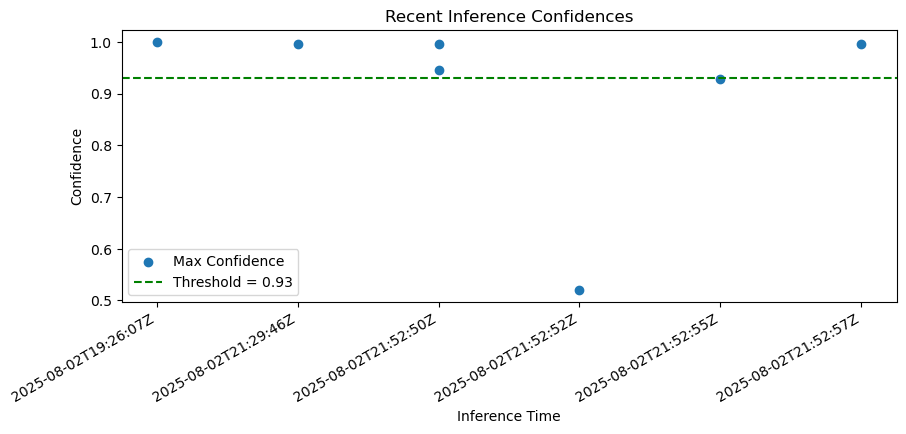

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.scatter(timestamps, max_conf, label="Max Confidence")
plt.axhline(0.93, color="green", linestyle="--", label="Threshold = 0.93")
plt.xlabel("Inference Time")
plt.ylabel("Confidence")
plt.title("Recent Inference Confidences")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


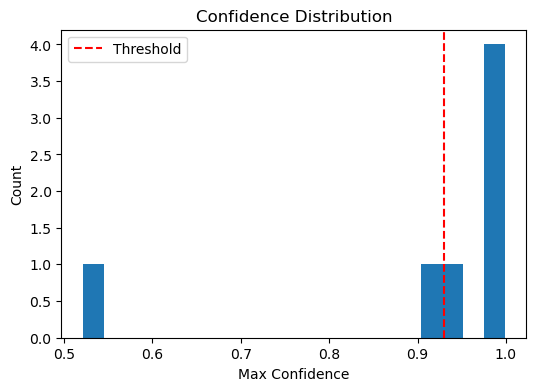

In [42]:
plt.figure(figsize=(6,4))
plt.hist(max_conf, bins=20)
plt.axvline(0.93, color="red", linestyle="--", label="Threshold")
plt.xlabel("Max Confidence")
plt.ylabel("Count")
plt.title("Confidence Distribution")
plt.legend()
plt.show()


# Scones Unlimited Image Classification Workflow

This project implements a serverless, end-to-end image classification pipeline using AWS services for the Scones Unlimited delivery routing system. It demonstrates modern ML operations (MLOps) practices by:

* **Extracting** and **preprocessing** CIFAR-100 images from S3 via an AWS Lambda function
* **Training** a SageMaker built-in Image Classification model
* **Deploying** the model to a real-time SageMaker endpoint
* **Orchestrating** inference using AWS Step Functions and Lambda
* **Capturing** and **visualizing** inference data with SageMaker Model Monitor

---

## 🏗 Architecture Overview

```text
CIFAR data (bicycle & motorcycle)
      ↓
S3 Bucket (train/, test/)
      ↓
SageMaker Training Job → SageMaker Endpoint
      ↓
Step Functions Workflow:
  1) serializeImageData Lambda
  2) classifyImage Lambda
  3) filterInferences Lambda → Succeed/Fail
      ↓
Model Monitor captures inputs & outputs → S3
      ↓
Notebook for Testing & Visualization
```

![Step Functions Workflow](screenshots/step_function_success.png)

---

## ⚙️ Components

### 1. Lambda Functions (in `lambda.py`)

* **`serializeImageData`**: Downloads an image from S3, base64-encodes it
* **`classifyImage`**: Invokes the SageMaker endpoint via `boto3` (`sagemaker-runtime`)
* **`filterInferences`**: Checks that the model’s confidence exceeds a threshold (0.93)

### 2. Step Functions (`step_function.json`)

A Standard state machine chains the three Lambdas. The final step is configured to fail loudly on low confidence (no Catch).

### 3. SageMaker Model

* **Training**: Used the built-in `image-classification` algorithm for 30 epochs on 2 classes (bicycle vs. motorcycle)
* **Deployment**: Deployed on `ml.m5.xlarge` with data-capture enabled (100% sampling)

---

## 🚀 Setup & Deployment

1. **Data Preparation**: Run the ETL notebook to extract CIFAR-100, filter classes 8 & 48, save images to S3.
2. **Training**: In the same notebook, configure and run the SageMaker Estimator.
3. **Deployment**: Deploy the trained model; note the endpoint name printed for later use.
4. **Lambda & Step Functions**:  Create three Lambdas with Python 3.9, attach necessary IAM policies, paste handler code, and deploy. Author the Step Function in the visual editor.
5. **Testing & Evaluation**: Use the provided `generate_test_case()` helper to trigger multiple executions. 

---

## 🔍 Testing & Evaluation

* **Step Function Executions**: Ran 5 randomized tests 
* **Model Monitor Visualization**:

  * **Scatter Plot** of inference confidence over time
  * **Histogram** of confidence distribution
---

## 🎯 Stretch Goals

* **Automated Alerts**: Configured CloudWatch Alarms on low-confidence errors
* **Batch Inference**: Extended workflow to process S3 folders of images via AWS Batch + Lambda
* **Custom Threshold Tuning**: Developed a small GUI to adjust threshold and redeploy Step Function

---

## 🧹 Cleanup

To avoid costs, remove all resources:

1. **Delete** the SageMaker endpoint, endpoint config, model
2. **Stop/Delete** notebook instances
3. **Delete** the Step Functions state machine
4. **Delete** all three Lambda functions
5. **Empty/Delete** the S3 bucket (train/, test/, data\_capture/)

---

## 📄 Files

* **`lambda.py`** – All three Lambda handlers
* **`step_function.json`** – Exported state machine definition
* **`screenshots/`** – Visuals of workflow and plots

---

*By Nour Shammaa*
